In [1]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('EURUSD_15m.csv')
data.tail()

timestamp      open      high       low     close  \
15369  2022-06-30 16:45:00+01:00  1.046682  1.048438  1.046572  1.047120   
15370  2022-06-30 17:00:00+01:00  1.047120  1.047340  1.046463  1.046792   
15371  2022-06-30 17:15:00+01:00  1.046682  1.047779  1.046682  1.047669   
15372  2022-06-30 17:30:00+01:00  1.047889  1.048218  1.047230  1.047449   
15373  2022-06-30 17:45:00+01:00  1.047779  1.048878  1.047779  1.048438   

       adj close  volumn  
15369   1.047120       0  
15370   1.046792       0  
15371   1.047669       0  
15372   1.047449       0  
15373   1.048438       0

In [6]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df

timestamp      open      high       low     close  adj close  \
0     2021-11-04 17:00:00  1.154734  1.155135  1.154734  1.155135   1.155135   
1     2021-11-04 17:15:00  1.155135  1.155535  1.155001  1.155135   1.155135   
2     2021-11-04 17:30:00  1.155001  1.155535  1.155001  1.155135   1.155135   
3     2021-11-04 17:45:00  1.155001  1.155535  1.155001  1.155001   1.155001   
4     2021-11-04 18:00:00  1.155135  1.155535  1.155135  1.155535   1.155535   
...                   ...       ...       ...       ...       ...        ...   
15369 2022-06-30 15:45:00  1.046682  1.048438  1.046572  1.047120   1.047120   
15370 2022-06-30 16:00:00  1.047120  1.047340  1.046463  1.046792   1.046792   
15371 2022-06-30 16:15:00  1.046682  1.047779  1.046682  1.047669   1.047669   
15372 2022-06-30 16:30:00  1.047889  1.048218  1.047230  1.047449   1.047449   
15373 2022-06-30 16:45:00  1.047779  1.048878  1.047779  1.048438   1.048438   

       volumn  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
15369       0  
15370       0  
15371       0  
15372       0  
15373       0  

[15374 rows x 7 columns]

In [20]:
class RSI_and_EMA:
    def __init__(self, params):
        
        self.current_action = 'close'
        self.atr = params['atr']
        self.ema = params['ema']
        self.rsi = params['rsi']
        
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        
        self.df = params['df']
        self.unknow_result = []
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
        self.total_tp = 0
        self.total_sl = 0
        self.total_order = 0
        
    def get_df(self):
        return self.df
        
    def create_orders(self):
        rsi_ema = ta.Strategy(
            name = 'RSI 14 Days for opposite trade',
            description = 'RSI for alert',
            ta = [
                {'kind': 'ema', 'length': self.ema},
                {'kind': 'rsi', 'length': self.rsi},
                {'kind': 'atr', 'length': self.atr}
            ]
        )
        
        self.df.ta.strategy(rsi_ema)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['action'] = None
        self.df['entries'] = False
        
        self.df['exits'] = False
        self.df['short_entries'] = False
        self.df['short_exits'] = False
        self.df['price_action'] = self.df['open']
        
        for index, row in self.df.iterrows():
            if self.current_action == 'close':

                if row['EMA_'+str(self.ema)] < row['low'] and row['RSI_'+str(self.rsi)] > self.overbought:
                    self.total_order = self.total_order + 1
                    self.order['action'] = 'buy'
                    
                    self.order['open time'] = row['timestamp']
                    self.order['open'] = row['open']
                    self.order['S/L'] = row['low'] - row['ATRr_'+str(self.atr)]
                    self.order['T/P'] = row['open'] + (self.rr * abs(row['open'] - self.order['S/L']))

                    self.df.at[index, 'action'] = 'buy'
                    self.df.at[index, 'entries'] = True
                    self.df.at[index, 'price_action'] = row['open']
                    self.current_action = 'buy'

                elif row['EMA_'+str(self.ema)] > row['high'] and row['RSI_'+str(self.rsi)] < self.oversold:
                    self.total_order = self.total_order + 1
                    self.order['action'] = 'sell'
                    
                    self.order['open time'] = row['timestamp']
                    self.order['open'] = row['open']
                    self.order['S/L'] = row['high'] + row['ATRr_'+str(self.atr)]
                    self.order['T/P'] = row['open'] - (self.rr * abs(row['open'] - self.order['S/L']))

                    self.df.at[index, 'action'] = 'sell'
                    self.df.at[index, 'short_entries'] = True
                    self.df.at[index , 'price_action'] = row['open']
                    self.current_action = 'sell'

            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.total_sl = self.total_sl + 1
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    self.current_action = 'close'

                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'S/L'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    self.order = {}
                    
                elif row['high'] >= self.order['T/P']:
                    self.total_tp = self.total_tp + 1
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    self.current_action = 'close'

                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'T/P'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    self.order = {}

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    self.total_sl = self.total_sl + 1
                    
                if row['high'] >= self.order['S/L']:
                    self.total_sl = self.total_sl + 1
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    self.current_action = 'close'

                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'S/L'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    self.order = {}
                    
                elif row['low'] <= self.order['T/P']:
                    self.total_tp = self.total_tp + 1
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    self.current_action = 'close'

                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'T/P'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    self.order = {}
  
        try:
            win_rate = round(self.total_tp * 100 / self.total_order, 2)
            loss_rate = round(self.total_sl * 100 / self.total_order, 2)
            gain = (self.total_tp * self.rr) - self.total_sl

            result_info = f"total orders: {self.total_order}, rsi: {self.rsi}, overbought: {self.overbought}, oversold: {self.oversold}, ema: {self.ema}, atr: {self.atr}, gain: {gain}"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': self.total_order, 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
            return {'win_rate': 0, 'info': 'No orders to action'}

In [21]:
pair_test = RSI_and_EMA({
    'atr': 17,
    'rsi': 10,
    'ema': 200,
    'overbought': 73,
    'oversold': 27,
    'pip_value': 0.001,
    'rr': 1.5,
    'df': df.copy()
})
result_test = pair_test.create_orders()
result_test

{'win_rate': 65.03,
 'info': 'total orders: 449, rsi: 10, overbought: 73, oversold: 27, ema: 200, atr: 17, gain: 282.0',
 'total_order': 449,
 'rr': 1.5,
 'gain': 282.0,
 'unknow': []}

In [22]:
pair_df = pair_test.get_df().copy()
# pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'], unit='ms')
pair_df = pair_df.set_index('timestamp')
pair_df

open      high       low     close  adj close  \
timestamp                                                                
2021-11-04 17:00:00  1.154734  1.155135  1.154734  1.155135   1.155135   
2021-11-04 17:15:00  1.155135  1.155535  1.155001  1.155135   1.155135   
2021-11-04 17:30:00  1.155001  1.155535  1.155001  1.155135   1.155135   
2021-11-04 17:45:00  1.155001  1.155535  1.155001  1.155001   1.155001   
2021-11-04 18:00:00  1.155135  1.155535  1.155135  1.155535   1.155535   
...                       ...       ...       ...       ...        ...   
2022-06-30 15:45:00  1.046682  1.048438  1.046572  1.047120   1.047120   
2022-06-30 16:00:00  1.047120  1.047340  1.046463  1.046792   1.046792   
2022-06-30 16:15:00  1.046682  1.047779  1.046682  1.047669   1.047669   
2022-06-30 16:30:00  1.047889  1.048218  1.047230  1.047449   1.047449   
2022-06-30 16:45:00  1.047779  1.048878  1.047779  1.048438   1.048438   

                     volumn   EMA_200     RSI_10   ATRr_17 action  entries  \
timestamp                                                                    
2021-11-04 17:00:00       0       NaN        NaN       NaN   None    False   
2021-11-04 17:15:00       0       NaN        NaN       NaN   None    False   
2021-11-04 17:30:00       0       NaN        NaN       NaN   None    False   
2021-11-04 17:45:00       0       NaN        NaN       NaN   None    False   
2021-11-04 18:00:00       0       NaN        NaN       NaN   None    False   
...                     ...       ...        ...       ...    ...      ...   
2022-06-30 15:45:00       0  1.047661  75.395561  0.001306   None    False   
2022-06-30 16:00:00       0  1.047652  71.966149  0.001281   None    False   
2022-06-30 16:15:00       0  1.047652  75.296675  0.001270   None    False   
2022-06-30 16:30:00       0  1.047650  72.889925  0.001254   None    False   
2022-06-30 16:45:00       0  1.047658  76.628102  0.001264    buy     True   

                     exits  short_entries  short_exits  price_action   T/P  \
timestamp                                                                    
2021-11-04 17:00:00  False          False        False      1.154734  None   
2021-11-04 17:15:00  False          False        False      1.155135  None   
2021-11-04 17:30:00  False          False        False      1.155001  None   
2021-11-04 17:45:00  False          False        False      1.155001  None   
2021-11-04 18:00:00  False          False        False      1.155135  None   
...                    ...            ...          ...           ...   ...   
2022-06-30 15:45:00  False          False        False      1.046682   NaN   
2022-06-30 16:00:00  False          False        False      1.047120   NaN   
2022-06-30 16:15:00  False          False        False      1.046682   NaN   
2022-06-30 16:30:00  False          False        False      1.047889   NaN   
2022-06-30 16:45:00  False          False        False      1.047779   NaN   

                      S/L  
timestamp                  
2021-11-04 17:00:00  None  
2021-11-04 17:15:00  None  
2021-11-04 17:30:00  None  
2021-11-04 17:45:00  None  
2021-11-04 18:00:00  None  
...                   ...  
2022-06-30 15:45:00   NaN  
2022-06-30 16:00:00   NaN  
2022-06-30 16:15:00   NaN  
2022-06-30 16:30:00   NaN  
2022-06-30 16:45:00   NaN  

[15374 rows x 17 columns]

In [54]:
pair_df.price_action

timestamp
2021-11-04 17:00:00    1.154734
2021-11-04 17:15:00    1.155135
2021-11-04 17:30:00    1.155001
2021-11-04 17:45:00    1.155001
2021-11-04 18:00:00    1.155135
                         ...   
2022-06-30 15:45:00    1.046682
2022-06-30 16:00:00    1.047120
2022-06-30 16:15:00    1.046682
2022-06-30 16:30:00    1.047889
2022-06-30 16:45:00    1.047779
Name: price_action, Length: 15374, dtype: float64

In [63]:
port = vbt.Portfolio.from_signals(pair_df.price_action,
                                  entries=pair_df.entries.astype('bool'),
                                  exits=pair_df.exits.astype('bool'),
                                  short_entries=pair_df.short_entries.astype('bool'),
                                  short_exits=pair_df.short_exits.astype('bool'),
                                  size=10,
                                  freq="15m",
                                  init_cash=100,
                                  fees=0.0025, 
                                  slippage=0.0025
                                 )

In [64]:
port.plot().show()

<AxesSubplot:xlabel='timestamp'>

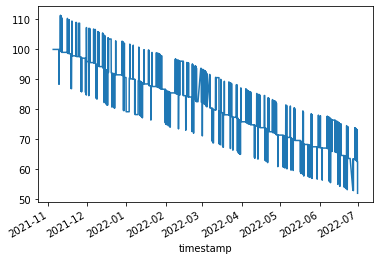

In [65]:
port.cash().plot()

In [66]:
port.stats()

Start                               2021-11-04 17:00:00
End                                 2022-06-30 16:45:00
Period                                160 days 03:30:00
Start Value                                       100.0
End Value                                     62.422763
Total Return [%]                             -37.577237
Benchmark Return [%]                          -9.262359
Max Gross Exposure [%]                        16.785203
Total Fees Paid                               19.694221
Max Drawdown [%]                              37.577237
Max Drawdown Duration                 157 days 20:30:00
Total Trades                                        358
Total Closed Trades                                 357
Total Open Trades                                     1
Open Trade PnL                                -0.052454
Win Rate [%]                                        0.0
Best Trade [%]                                 -0.52596
Worst Trade [%]                               -1

In [67]:
port.orders.records_readable

Order Id  Column           Timestamp  Size     Price      Fees  Side
0           0       0 2021-11-09 05:15:00  10.0  1.163263  0.029082   Buy
1           1       0 2021-11-09 06:00:00  10.0  1.158537  0.028963  Sell
2           2       0 2021-11-10 07:30:00  10.0  1.154247  0.028856  Sell
3           3       0 2021-11-10 09:30:00  10.0  1.161242  0.029031   Buy
4           4       0 2021-11-10 11:45:00  10.0  1.152380  0.028809  Sell
..        ...     ...                 ...   ...       ...       ...   ...
710       710       0 2022-06-30 11:15:00  10.0  1.038197  0.025955  Sell
711       711       0 2022-06-30 11:30:00  10.0  1.041234  0.026031   Buy
712       712       0 2022-06-30 11:45:00  10.0  1.036794  0.025920  Sell
713       713       0 2022-06-30 12:15:00  10.0  1.043401  0.026085   Buy
714       714       0 2022-06-30 16:45:00  10.0  1.050398  0.026260   Buy

[715 rows x 7 columns]

In [70]:
port.trades.records_readable

Exit Trade Id  Column  Size     Entry Timestamp  Avg Entry Price  \
0                0       0  10.0 2021-11-09 05:15:00         1.163263   
1                1       0  10.0 2021-11-10 07:30:00         1.154247   
2                2       0  10.0 2021-11-10 11:45:00         1.152380   
3                3       0  10.0 2021-11-10 15:15:00         1.151981   
4                4       0  10.0 2021-11-10 15:45:00         1.149194   
..             ...     ...   ...                 ...              ...   
353            353       0  10.0 2022-06-29 18:45:00         1.042102   
354            354       0  10.0 2022-06-30 10:45:00         1.039279   
355            355       0  10.0 2022-06-30 11:15:00         1.038197   
356            356       0  10.0 2022-06-30 11:45:00         1.036794   
357            357       0  10.0 2022-06-30 16:45:00         1.050398   

     Entry Fees      Exit Timestamp  Avg Exit Price  Exit Fees       PnL  \
0      0.029082 2021-11-09 06:00:00        1.158537   0.028963 -0.105309   
1      0.028856 2021-11-10 09:30:00        1.161242   0.029031 -0.127837   
2      0.028809 2021-11-10 13:15:00        1.159362   0.028984 -0.127610   
3      0.028800 2021-11-10 15:30:00        1.154821   0.028871 -0.086073   
4      0.028730 2021-11-10 16:00:00        1.156419   0.028910 -0.129899   
..          ...                 ...             ...        ...       ...   
353    0.026053 2022-06-30 02:15:00        1.048421   0.026211 -0.115452   
354    0.025982 2022-06-30 11:00:00        1.042642   0.026066 -0.085675   
355    0.025955 2022-06-30 11:30:00        1.041234   0.026031 -0.082351   
356    0.025920 2022-06-30 12:15:00        1.043401   0.026085 -0.118074   
357    0.026260 2022-06-30 16:45:00        1.047779   0.000000 -0.052454   

       Return Direction  Status  Position Id  
0   -0.009053      Long  Closed            0  
1   -0.011075     Short  Closed            1  
2   -0.011074     Short  Closed            2  
3   -0.007472     Short  Closed            3  
4   -0.011304     Short  Closed            4  
..        ...       ...     ...          ...  
353 -0.011079     Short  Closed          353  
354 -0.008244     Short  Closed          354  
355 -0.007932     Short  Closed          355  
356 -0.011388     Short  Closed          356  
357 -0.004994      Long    Open          357  

[358 rows x 14 columns]